In [1]:
%cd ..

/workspace/shai_hulud/ppc_experiments


In [2]:
import argparse
import collections
import lightning
import numpy as np
import pyro
import torch
import logger, train

Seed set to 123


In [3]:
# pyro.enable_validation(True)
# torch.autograd.set_detect_anomaly(True)

In [4]:
config, (data, model, trainer) = train.from_file("experiments/ppc_celeba_config.json")

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [5]:
logger = config.get_logger('valid')

In [6]:
trainer.fit(model, data, ckpt_path="saved/models/CelebA_Ppc/0512_233011/checkpoint_14.ckpt")

Missing logger folder: saved/log/CelebA_Ppc/0513_230026/lightning_logs


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:653: Checkpoint directory /workspace/shai_hulud/ppc_experiments/saved/models/CelebA_Ppc/0513_230026 exists and is not empty.
Restoring states from the checkpoint path at saved/models/CelebA_Ppc/0512_233011/checkpoint_14.ckpt
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:361: The dirpath has changed from '/workspace/shai_hulud/ppc_experiments/saved/models/CelebA_Ppc/0512_233011' to '/workspace/shai_hulud/ppc_experiments/saved/models/CelebA_Ppc/0513_230026', therefore `best_model_score`, `kth_best_model_path`, `kth_value`, `last_model_path` and `best_k_models` won't be reloaded. Only `best_model_path` will be reloaded.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name       | Type       | Params
------------------------------------------
0 | graph      | CelebAPpc  | 401 K 
1 | predictive | Predictive | 0     
----------------------------------

Sanity Checking: |                                                                                            …

`Trainer.fit` stopped: `max_epochs=15` reached.


In [7]:
model.graph.clear()
model.eval()
model.cpu()
model.particles['valid'].cpu()

ParticleDict(  (z): Parameter containing: [torch.FloatTensor of size 4x19867x40])

In [8]:
xs, _, indices = list(data.val_dataloader())[0]
model._load_particles(indices, False)

In [9]:
trace, _ = model.graph(P=model.num_particles, xs=xs)
x_hats = trace.nodes['X']['fn'].base_dist.loc.mean(dim=0)

In [10]:
import matplotlib.pyplot as plt

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


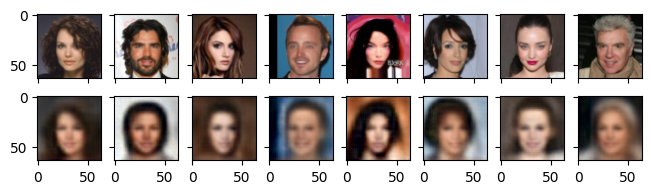

In [11]:
fig, axes = plt.subplots(nrows=2, ncols=8, sharex="all", sharey="all", layout="compressed")

for i in range(8):
    orgs = xs[i].squeeze().detach().transpose(0, -1)
    estimates = x_hats[i].squeeze().detach().transpose(0, -1)
    axes[0, i].imshow(orgs)
    axes[1, i].imshow(estimates)

fig.savefig("ppc_celeba_recons.pdf", bbox_inches="tight")
plt.show()

In [12]:
del xs
del x_hats

In [13]:
model.graph.clear()

In [14]:
x_hats = model.graph(P=model.num_particles, B=8, prior=True).mean(dim=0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


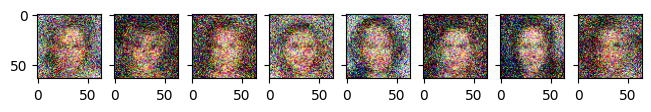

In [15]:
fig, axes = plt.subplots(nrows=1, ncols=8, sharex="all", sharey="all", layout="compressed")

for i in range(8):
    estimates = x_hats[i].squeeze().detach().transpose(0, -1)
    axes[i].imshow(estimates)

fig.savefig("ppc_celeba_samples.pdf", bbox_inches="tight")
plt.show()

In [16]:
del x_hats

In [17]:
SEEDS = [123, 456, 789, 101112, 131415]

In [18]:
LOG_LIKELIHOODS = torch.zeros(len(SEEDS), requires_grad=False)
MEAN_SQUARED_ERROR = torch.zeros(len(SEEDS), requires_grad=False)

In [19]:
for (s, SEED) in enumerate(SEEDS):
    torch.manual_seed(SEED)
    np.random.seed(SEED)
    for b, (xs, target, indices) in enumerate(data.val_dataloader()):
        model._load_particles(indices, False)

        trace, _ = model.graph(P=model.num_particles, xs=xs)
        x_hats = trace.nodes['X']['value'].mean(dim=0)
        LOG_LIKELIHOODS[s] += trace.nodes['X']['fn'].log_prob(xs).sum()
        MEAN_SQUARED_ERROR[s] += ((xs - x_hats) ** 2).sum(dim=0).mean()

        del xs
        del x_hats
        logger.info("Evaluated likelihood for valid batch %d under seed %s" % (b, s))

    LOG_LIKELIHOODS[s] /= len(data.val_dataloader().dataset)
    MEAN_SQUARED_ERROR[s] /= len(data.val_dataloader().dataset)

Evaluated likelihood for valid batch 0 under seed 0
Evaluated likelihood for valid batch 1 under seed 0
Evaluated likelihood for valid batch 2 under seed 0
Evaluated likelihood for valid batch 3 under seed 0
Evaluated likelihood for valid batch 4 under seed 0
Evaluated likelihood for valid batch 5 under seed 0
Evaluated likelihood for valid batch 6 under seed 0
Evaluated likelihood for valid batch 7 under seed 0
Evaluated likelihood for valid batch 8 under seed 0
Evaluated likelihood for valid batch 9 under seed 0
Evaluated likelihood for valid batch 0 under seed 1
Evaluated likelihood for valid batch 1 under seed 1
Evaluated likelihood for valid batch 2 under seed 1
Evaluated likelihood for valid batch 3 under seed 1
Evaluated likelihood for valid batch 4 under seed 1
Evaluated likelihood for valid batch 5 under seed 1
Evaluated likelihood for valid batch 6 under seed 1
Evaluated likelihood for valid batch 7 under seed 1
Evaluated likelihood for valid batch 8 under seed 1
Evaluated li

In [20]:
LOG_LIKELIHOODS.mean(), LOG_LIKELIHOODS.std()

(tensor(-23054.7871, grad_fn=<MeanBackward0>),
 tensor(0.3999, grad_fn=<StdBackward0>))

In [21]:
MEAN_SQUARED_ERROR.mean(), MEAN_SQUARED_ERROR.std()

(tensor(0.0734), tensor(0.))